# Video Game Sales Analysis Project
Raphael Lu
## Project Overview

The purpose of this project was to characterize video games that came to market from 1980 through 2016. 

We looked at historic sales history of all games considering variables such as genre, platform, year of game release, and regional performance. Analyses were focused on the past 3 years (2013 to 2016) for a representative look at platform market lifecycles. Specifically, we addressed sales volume, year-over-year performance of the top 5 platforms, and sales distribution by platform. Taking the top 5 performing unique game franchises, we assessed performance across platforms. Genre performances were addressed by sales volume. Descriptive statistics were obtained for regional sales and ESRB ratings. The correlation between user_scores v. critic_score was also assessed. 

We explored average user scores of games on both XBox and PC (paired-samples) and average user score between Action and Sport genres (independent samples). No pre-assumptions were made at outset. 

Statistical analysis were performed using the stats subpackage of the SciPy library. Confidence levels were set a-prioi at alpha = 0.05. Missing data points (post 2000's User Score) were filled using multiple imputations. Analysis between groups (independent samples) were performed using the independent samples T-test. Analysis within groups were performed using dependent samples T-test. 

Identifying key characteristics of games will allow for us to focus advertising campaigns for the upcoming 2017 fiscal year.

## Environment Setup and Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## 1. Loading and Initial Data Exploration

First, let's load our dataset and examine its basic properties:

In [2]:
# Load the dataset

filename = 'games.csv'
paths = [
    '/datasets',
    '/Users/raphaellu/Documents/Triple Ten Projects/my-portfolio/datasets'
]

games_df = next(
    pd.read_csv(f'{path}/{filename}') 
    for path in paths 
    if pd.io.common.file_exists(f'{path}/{filename}')
)

In [3]:
# Display basic information about the dataset
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
print(f'Number of Duplicate Records: {games_df.duplicated().sum()}')
print(games_df.sample(2, random_state = 42))

Number of Duplicate Records: 0
                                                   Name Platform  \
3485  London 2012: The Official Video Game of the Ol...     X360   
5500                                     Etrian Odyssey       DS   

      Year_of_Release         Genre  NA_sales  EU_sales  JP_sales  \
3485           2012.0        Sports      0.07      0.44      0.00   
5500           2007.0  Role-Playing      0.19      0.02      0.09   

      Other_sales  Critic_Score User_Score Rating  
3485         0.07           NaN        NaN    NaN  
5500         0.02          75.0        8.5      T  


In [5]:
print(f"Unique User Scores: {games_df['User_Score'].unique()}")
print()
print(f"Unique Ratings: {games_df['Rating'].unique()}")
print()
print(f"Unique Ratings: {games_df['Genre'].unique()}")

Unique User Scores: ['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']

Unique Ratings: ['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']

Unique Ratings: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy' nan]


### Key Contents:
- Records: 16,715 (no duplicates found)
- Feilds: 11, containing mix of object and float
- Data Issues:
    - Feild `User_Score` should be coded as float64
    - Feild `Year_of_Reelease` may converted to int64 or object
    - Names of feilds should be converted to `lower_case_underscore` style
    - Null values are present in `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`, and `Rating`
    - `User_Score` has scores notes as tbd (to be determined)

## 2 Data Preparation

### 2.1 Standardizing Column Names

In [6]:
# Convert column names to lowercase
games_df.columns = games_df.columns.str.lower()

In [7]:
# Verify the changes
print(games_df.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


### 2.2 Data Type Conversion

- Year converted to Int64 for more intunitive analysis
- `user_score` converted to float64 to allow arithmatic functions
    - To be determined (`tbd`) User Scores converted to `NaN` for easier analysis. However values are preserved in new column `is_tbd`.

In [8]:
games_df['year_of_release'] = pd.to_numeric(games_df['year_of_release']).astype('Int64')

print(games_df['year_of_release'].unique())

<IntegerArray>
[2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010, 2013, 2004,
 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014, 1992, 1997, 1993, 1994,
 1982, 2016, 2003, 1986, 2000, <NA>, 1995, 1991, 1981, 1987, 1980, 1983]
Length: 38, dtype: Int64


In [9]:
# Pay attention to the abbreviation TBD (to be determined). Specify how you intend to handle such cases.
games_df['us_tbd'] = games_df['user_score'] == 'tbd'
games_df['user_score'] = pd.to_numeric(games_df['user_score'], errors = 'coerce')

### 2.3 Handling Missing Values

- Records 659 and 14244 are missing name, genre, scores, and rating.
- In initial sampling of the dataframe, it appears that `critic_score`, `user_score`, and `rating` seem to be missing concurrently
    - Further data exploration suggests that these metrics were not common before 2000, with a majority of games (>50%) missing scores in years prior
- Of note, it appears that in records with missing `year_of_release` a year is included in the game title

<b>Handling:</b>
- `year_of_release` was extrapolated from game `name`
    - Years based off of known naming conventions i.e.:
      - FIFA 14 --> 2014
      - NBA Live 2003 --> 2003
      - Major League Baseball 2K12
    - It was assumed that years tended to be come at the end of game names, and that mid-string numbers were descriptors (i.e. Drake of the 99 Dragons )
    - When multiple years were present, the more recent year was taken
    - Games released on Nintendo 64 tended to have 64 in the name; years were extrapolated to 1998, the approximate 'mid-life' of the platform
      
- `user_score`: to preserve variability and uncertainty, multiple imputations were performed.
    - Assuming that it was not industry standard to score games prior to 2000, only post 2000 game score were imputed
    - First data were statified by genre
    - Then at least 5 `user_score`(weighted at 0.7) and `critic_score`(weighted at 0.3) were taken from the same year (expanded to +/- 2 years if more score were needed)
    - 5 imputations were run, with the average of each imputation then returned to the dataframe
    - For this project we assume that these imputations were reliable predictors and TBD scores were disregarded (but preserved in feild `is_tbd`)

In [10]:
# Examine missing values
for col in games_df.columns:
    if games_df[col].notna().sum() < len(games_df):
        print(f"Values Missing in `{col}`:" )
        print(games_df[games_df[col].isna()].sample(4, random_state=42, replace=True))
        print("------------------------")
    else:
        print(f"No Missing Values in `{col}`" )
        print("------------------------")


Values Missing in `name`:
      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN             1993   NaN      1.78      0.53      0.00   
14244  NaN      GEN             1993   NaN      0.00      0.00      0.03   
659    NaN      GEN             1993   NaN      1.78      0.53      0.00   
659    NaN      GEN             1993   NaN      1.78      0.53      0.00   

       other_sales  critic_score  user_score rating  us_tbd  
659           0.08           NaN         NaN    NaN   False  
14244         0.00           NaN         NaN    NaN   False  
659           0.08           NaN         NaN    NaN   False  
659           0.08           NaN         NaN    NaN   False  
------------------------
No Missing Values in `platform`
------------------------
Values Missing in `year_of_release`:
                          name platform  year_of_release    genre  na_sales  \
6773     Mega Man X Collection      PS2             <NA>     Misc      0.12   
6954  

In [11]:
# Calculate percentage of missing values
for col in games_df.columns:
    if games_df[col].notna().sum() < len(games_df):
        print(f"% Missing in `{col}`:" )
        print(f"{(games_df[col].isna().mean() * 100).round(2)}%")
        print("------------------------------")
    else:
        print(f"No Missing Values in `{col}`" )
        print("------------------------------")

% Missing in `name`:
0.01%
------------------------------
No Missing Values in `platform`
------------------------------
% Missing in `year_of_release`:
1.61%
------------------------------
% Missing in `genre`:
0.01%
------------------------------
No Missing Values in `na_sales`
------------------------------
No Missing Values in `eu_sales`
------------------------------
No Missing Values in `jp_sales`
------------------------------
No Missing Values in `other_sales`
------------------------------
% Missing in `critic_score`:
51.32%
------------------------------
% Missing in `user_score`:
54.59%
------------------------------
% Missing in `rating`:
40.48%
------------------------------
No Missing Values in `us_tbd`
------------------------------


In [12]:
#genres = games_df['genre'].unique()

nan_year = games_df.groupby('year_of_release')[['user_score', 'critic_score', 'rating']].apply(lambda x: x.isna().mean() * 100)

nan_rate = games_df[games_df['year_of_release'] >= 2000] \
    .groupby('rating')[['user_score', 'critic_score']] \
    .apply(lambda x: x.isna().mean() * 100)

print("Tables of Percent of Missing Values")
print(nan_year)
print(nan_rate)

Tables of Percent of Missing Values
                 user_score  critic_score      rating
year_of_release                                      
1980             100.000000    100.000000  100.000000
1981             100.000000    100.000000  100.000000
1982             100.000000    100.000000  100.000000
1983             100.000000    100.000000  100.000000
1984             100.000000    100.000000  100.000000
1985              92.857143     92.857143   92.857143
1986             100.000000    100.000000  100.000000
1987             100.000000    100.000000  100.000000
1988              93.333333     93.333333   93.333333
1989             100.000000    100.000000  100.000000
1990             100.000000    100.000000  100.000000
1991             100.000000    100.000000  100.000000
1992              97.674419     97.674419   95.348837
1993             100.000000    100.000000  100.000000
1994              99.173554     99.173554   99.173554
1995             100.000000    100.000000  100

In [13]:
#Replace NaN in rating with 'Unknown'

games_df['rating'] = games_df['rating'].fillna('Unknown')

In [14]:
#extract year from name of game

year_pattern = r'198\d|199\d|2K0\d|2K1[0-6]|200\d|201[0-6]'
year_2_pattern = r'[0-9][0-9]$'

for r in games_df.index:
    if pd.isna(games_df.loc[r,'year_of_release']):
        if pd.notna(games_df.loc[r, 'name']):
            matches = re.findall(year_pattern, games_df.loc[r, 'name'])
            matches_2 = re.search(year_2_pattern, games_df.loc[r, 'name'])
            if matches:
                matches = [int(year_str.replace('K', '0')) for year_str in matches]
                games_df.loc[r,'year_of_release'] = max(matches)
            elif matches_2:
                matches_2 = int(matches_2.group())
                if matches_2 == 64:
                    games_df.loc[r,'year_of_release'] = 1998 #assume Nintendo 64 games came out in 1998
                elif matches_2 >= 80: 
                    games_df.loc[r,'year_of_release'] = matches_2 + 1899    
                elif matches_2 >= 17:
                    games_df.loc[r,'year_of_release'] = np.nan
                else:
                    games_df.loc[r,'year_of_release'] = matches_2 + 1999
            else:
                games_df.loc[r,'year_of_release'] = np.nan

In [15]:
#multiple imputations of missing data

# take post 2000 games
post_2000_data = games_df[games_df['year_of_release'] > 2000].copy()

# creates matrix (two columns) of weighted scores
def create_weighted_features(df):
    user_scores = df['user_score'].values
    critic_scores = df['critic_score'].values
    return np.column_stack([ 
        user_scores * 0.7,
        critic_scores * 0.3
    ])

# get group for imputation (same genre, ±2 years)
def get_imputation_group(df, genre, year, window=2, min_samples=5):
    group = df[
        (df['genre'] == genre) &
        (df['year_of_release'].between(year - window, year + window)) &
        (~df['critic_score'].isna())
    ]
    return group if len(group) >= min_samples else pd.DataFrame()

# main batch imputation func
def batch_impute_user_scores(df, n_imputations=5):
    imputed_datasets = []

    for i in range(n_imputations):
        imputed_data = df.copy()

        for genre in imputed_data['genre'].unique():
            genre_df = imputed_data[imputed_data['genre'] == genre]

            for year in genre_df['year_of_release'].dropna().unique():
                group = get_imputation_group(imputed_data, genre, year)

                # Try to impute using IterativeImputer
                if not group.empty and group['user_score'].isna().sum() > 0:
                    features = group[['user_score', 'critic_score']].copy()
                    weighted = create_weighted_features(features)

                # Impute user_score using IterativeImputer
                    try:
                        imputer = IterativeImputer(random_state=i, max_iter=10, sample_posterior=True)
                        
                        #features selects the scores for imputation
                        features = group[['user_score', 'critic_score']].copy()
                        
                        #call the function to weight the scores, returns a matrix
                        weighted = create_weighted_features(features)

                        #apply/fit the known data 
                        imputed_array = imputer.fit_transform(weighted)
                        
                        #undo the prior weighting (all rows and column 0, the user_scores)
                        imputed_scores = imputed_array[:, 0] / 0.7

                        imputed_data.loc[group.index, 'user_score'] = imputed_scores

                    except Exception as e:
                        print(f"Imputation failed for genre: {genre}, year: {year} — {e}")

        imputed_datasets.append(imputed_data)

    return imputed_datasets

imputed_versions = batch_impute_user_scores(post_2000_data, n_imputations=5)



In [16]:
#Pull imputations back into dataframe
final_imputed = post_2000_data.copy()

# Stack all user_score columns
user_score_imputations = pd.concat(
    [df[['user_score']] for df in imputed_versions],
    axis=1
)

# Name the columns
user_score_imputations.columns = [f"user_score_imp_{i+1}" for i in range(len(imputed_versions))]

# Average across imputations, but only for originally missing values
final_imputed['user_score_imputed'] = user_score_imputations.mean(axis=1)

# Fill in only where user_score was missing
final_imputed['user_score'] = final_imputed['user_score'].combine_first(final_imputed['user_score_imputed'])

# Optionally drop the temporary column
final_imputed = final_imputed.drop(columns=['user_score_imputed'])

games_df_imp = games_df.copy()
games_df_imp.update(final_imputed[['user_score']])


In [17]:
games_df_imp = games_df.copy()
games_df_imp.update(final_imputed[['user_score']])

Here we preserve one dataframe with imputations `games_df_imp` and the original `games_df`

### 2.4 Calculate Total Sales

In [18]:
# Calculate total sales across all regions and put them in a different column
games_df['total_sales'] = games_df['na_sales'] + games_df['eu_sales'] + games_df['other_sales']
games_df_imp['total_sales'] = games_df_imp['na_sales'] + games_df['eu_sales'] + games_df['other_sales']

In [19]:
### Standardizing Game Scoring to 100
games_df['user_score'] *= 10
games_df_imp['user_score'] *= 10

# Step 3: Analyzing Video Game Sales Data

## 3.1 Temporal Analysis of Game Releases
Let's first examine the distribution of game releases across different years to understand our data's coverage and significance:

In [20]:
# Create a DataFrame with game releases by year
year_df = games_df.groupby('year_of_release')['name'].count().reset_index()
year_df.columns = ['year_of_release', 'game_count']


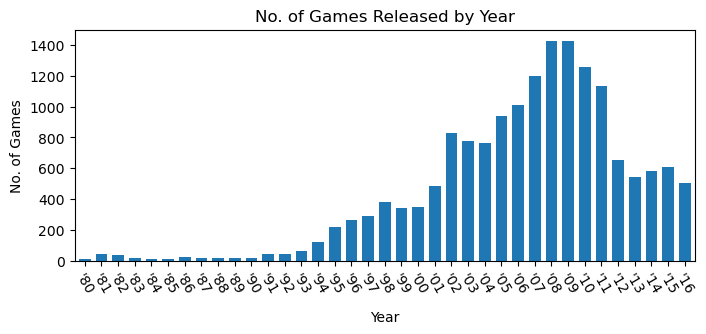

In [21]:
# Visualize the distribution of games across years
year_df.plot(kind= 'bar', x = 'year_of_release', title='No. of Games Released by Year', legend=False,
            ylabel='No. of Games', figsize=[8, 3], rot=300, width = .70)
plt.xlabel(xlabel= 'Year',labelpad = 10)
plt.xticks(np.arange(0,37) , [f"'{str(y)[2:]}" for y in year_df['year_of_release']])
plt.show()

In [22]:
# Display summary statistics for each year
print(year_df)

    year_of_release  game_count
0              1980           9
1              1981          46
2              1982          36
3              1983          17
4              1984          14
5              1985          14
6              1986          21
7              1987          16
8              1988          15
9              1989          17
10             1990          16
11             1991          41
12             1992          43
13             1993          60
14             1994         121
15             1995         219
16             1996         263
17             1997         289
18             1998         381
19             1999         339
20             2000         350
21             2001         482
22             2002         831
23             2003         779
24             2004         764
25             2005         942
26             2006        1010
27             2007        1198
28             2008        1429
29             2009        1427
30      

### Considerations:
- Video game production peaked in 2008 (1427 games) and 2009 (1426 games)
- There was a net decline in video game production after 2009
    - Potential influence from the '07-'09 The Great Recession in the US? 
- There is likely enough information to model projections for the 2017 fiscal year. 

## 3.2 Platform Sales Analysis Over Time

Now let's analyze how sales vary across platforms and years:

In [23]:
# Calculate total sales by platform and year
platform_sales = games_df.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()

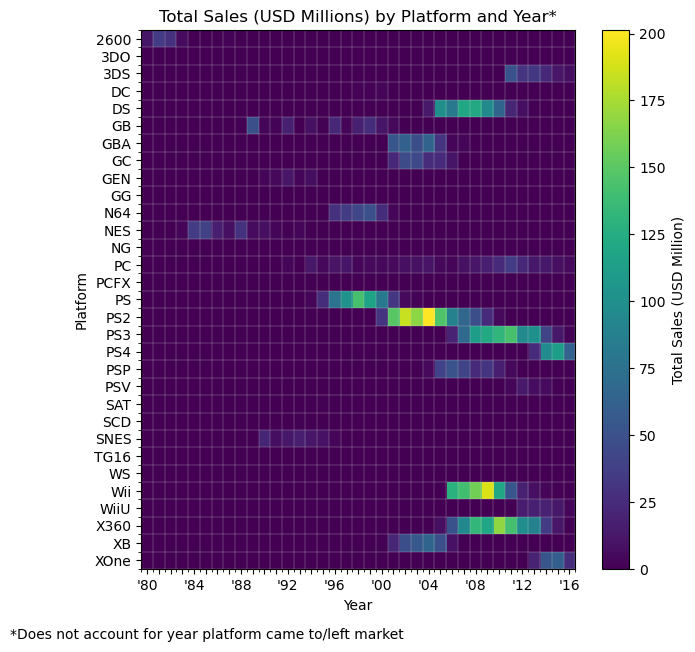

In [24]:
# Create a heatmap of platform sales over time
heatmap_games = platform_sales.pivot(index='platform', columns='year_of_release', values='total_sales')
heatmap_games = heatmap_games.fillna(0)

# Create the heatmap
plt.figure(figsize=(7, 7))
plt.imshow(heatmap_games.values, aspect='auto')

years = year_df['year_of_release']
labels = [f"'{str(y)[2:]}" if i % 4 == 0 else '' for i, y in enumerate(years)]
plt.xticks(np.arange(len(years)), labels)
plt.yticks(ticks=np.arange(len(heatmap_games.index)), labels=heatmap_games.index)

# Add colorbar
plt.colorbar(label='Total Sales (USD Million)')

plt.title('Total Sales (USD Millions) by Platform and Year*')
plt.xlabel('Year')
plt.ylabel('Platform')
#plt.tight_layout()

plt.gca().set_xticks(np.arange(-.5, heatmap_games.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, heatmap_games.shape[0], 1), minor=True)
plt.grid(which='minor', color='lightgrey', linestyle='-', linewidth=0.2)

plt.figtext(0.5, 0.01,'*Does not account for year platform came to/left market', horizontalalignment='right', fontsize=10)

plt.show()

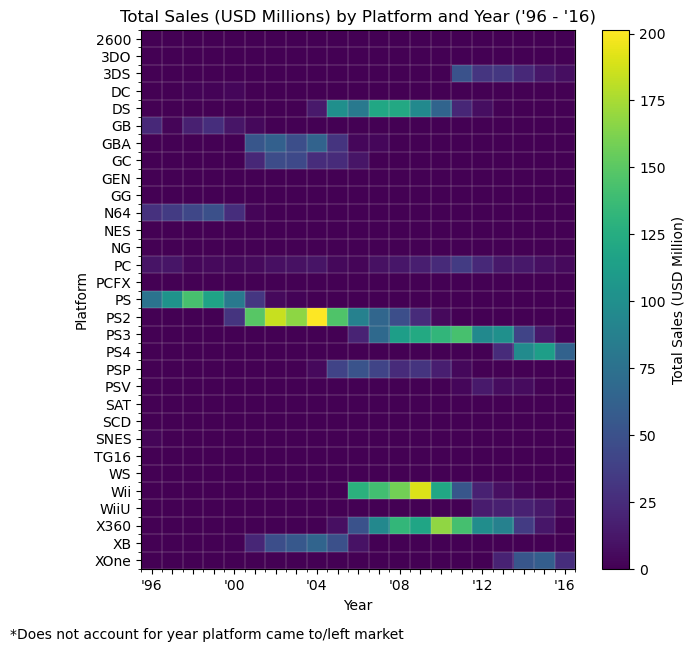

In [25]:
# Heatmap of 1996 to 2016
selected_years = [y for y in heatmap_games.columns if 1996 <= y <= 2016]
heatmap_games_selected = heatmap_games[selected_years]

plt.figure(figsize=(7, 7))
plt.imshow(heatmap_games_selected.values, aspect='auto')  # autoscale colors

# Set x-tick labels for selected years
labels = [f"'{str(y)[2:]}" if (i % 4 == 0) else '' for i, y in enumerate(selected_years)]
plt.xticks(np.arange(len(selected_years)), labels)
plt.yticks(ticks=np.arange(len(heatmap_games_selected.index)), labels=heatmap_games_selected.index)

plt.colorbar(label='Total Sales (USD Million)')
plt.title('Total Sales (USD Millions) by Platform and Year (\'96 - \'16)')
plt.xlabel('Year')
plt.ylabel('Platform')

plt.gca().set_xticks(np.arange(-.5, heatmap_games_selected.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, heatmap_games_selected.shape[0], 1), minor=True)
plt.grid(which='minor', color='lightgrey', linestyle='-', linewidth=0.2) 

plt.figtext(0.5, 0.01,'*Does not account for year platform came to/left market', horizontalalignment='right', fontsize=10)

plt.show()

Past 20 years enlarged to better visualize recent trends. 

### Sales Patterns:

- Sales were in decline across all platforms leading up to the end of 2016
- Marked recent peaks sales (past 8 years) was seen in the 3DS, DS, PS3, PS4, Wii, X360, and XOne.
    - A slight peak was seen with WiiU but total annual sales were relatively small (<~25 Mil. USD)
    - Most recent peaks were seen in XOne (2015), PS4 (2015)
- Platforms with the highest peaks (>157 Mil. USD) were PS2 (2004) and Wii (2009)
- Continuous dark blue lines indicate periods before and after a platform enters and leaves the market
- Most platforms appear to remain popular for a period of 8 years
- PC and GB games saw a longer duration on the market (possibly related to (backwards compatabilty with newer platforms))



## 3.3 Determining Relevant Time Period

Based on these trends, we will focus on the past 12 years. This time period captures the popularity cycle of recent iterations of the DS, PlayStation, Wii, and XBox. 

In [26]:
# filter the dataset to relevant years
relevant_years = list(range(2013, 2017)) 
df_relevant = games_df_imp[games_df_imp['year_of_release'].isin(relevant_years)]

## 3.4 Platform Performance Analysis

<b>Findings:</b>

 - PS4, XOne, and PS3 were the top grossing platforms each making over $150 Million USD over the past 3 years
 - Other than Wii and 3DS, see a marked elevation in year-over-year sales in the year following initial platform release
     - This is likely contributed to mid-year platform releases and limited game availablity when platforms first enter the market
     - After initial release, platforms tend to see positive year-over-year sales for around 3-5 years
 - At the end of 2016, all platforms were in negative year-over-year sales
 - Notably, all new platforms (inital release post 2011), ended in negative year-over-year sales
     - 3DS and PSV are seeing a slight decrease in rate of sales volume loss

<b>Visualizations Displayed Below</b>

In [27]:
# Sort platforms by total sales
relev_plat_sales = df_relevant.groupby(['platform'])['total_sales'].sum().reset_index()
relev_plat_sales = relev_plat_sales.sort_values('total_sales', ascending = True)

relev_plat_sales = relev_plat_sales[relev_plat_sales["total_sales"] != 0]

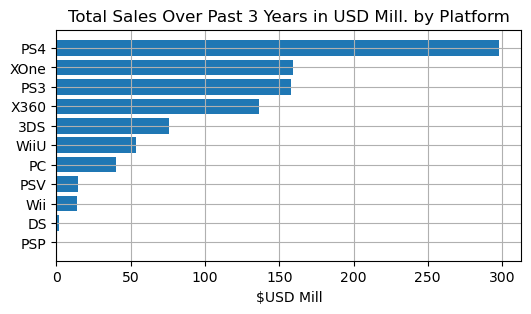

In [28]:
# Visualize top platforms
plt.figure(figsize = [6,3])
plt.title('Total Sales Over Past 3 Years in USD Mill. by Platform')
plt.xlabel('$USD Mill')
plt.grid(True)
plt.barh(relev_plat_sales['platform'],relev_plat_sales['total_sales'])
plt.show()

In [29]:
#getting release years of each platform

release_year = df_relevant.groupby('platform')['year_of_release'].min()

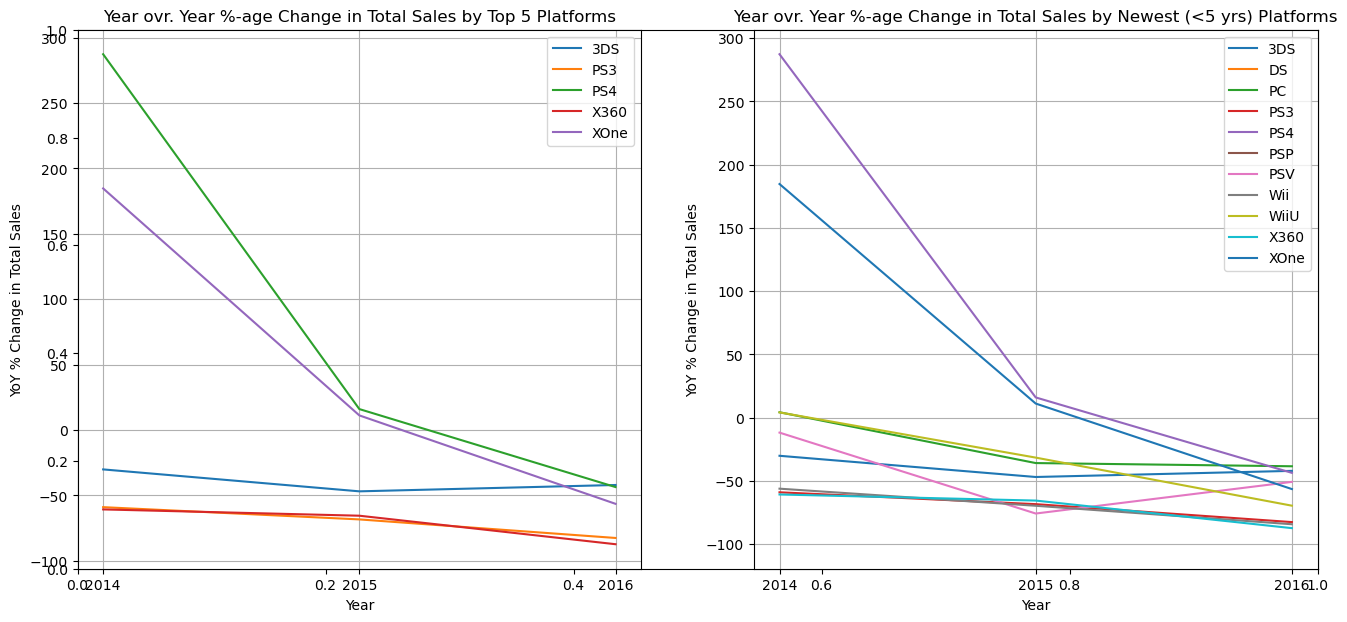

In [30]:
#yoy plotting
top_plat = relev_plat_sales['platform'].tail(5).reset_index(drop=True) #sales were in ascending order 
new_plat = release_year[release_year >= 2011].index.to_series(index=None)

top_plat_sales = df_relevant[df_relevant['platform'].isin(top_plat)]
new_plat_sales = df_relevant[df_relevant['platform'].isin(new_plat)]

top_yoy = top_plat_sales.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()
top_yoy = top_yoy.sort_values(['platform', 'year_of_release'])
top_yoy['yoy_pct_change'] = top_yoy.groupby('platform')['total_sales'].pct_change() * 100

new_yoy = new_plat_sales.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()
new_yoy = new_yoy.sort_values(['platform', 'year_of_release'])
new_yoy['yoy_pct_change'] = new_yoy.groupby('platform')['total_sales'].pct_change() * 100

plt.subplots(figsize=(16, 7))
plt.subplot(1, 2, 1)

for plat in top_yoy['platform'].unique():
    df_plot = top_yoy[top_yoy['platform'] == plat]
    plt.plot(df_plot['year_of_release'], df_plot['yoy_pct_change'], label=plat)

plt.title('Year ovr. Year %-age Change in Total Sales by Top 5 Platforms')
plt.xlabel('Year')
plt.xticks([2014,2015,2016])
plt.ylabel('YoY % Change in Total Sales')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for plat in new_yoy['platform'].unique():
    df_plot = new_yoy[new_yoy['platform'] == plat]
    plt.plot(df_plot['year_of_release'], df_plot['yoy_pct_change'], label=plat)

plt.title('Year ovr. Year %-age Change in Total Sales by Newest (<5 yrs) Platforms')
plt.xlabel('Year')
plt.xticks([2014,2015,2016])
plt.ylabel('YoY % Change in Total Sales')
plt.legend()
plt.grid(True)

plt.show()

### 3.5 Sales Distribution Analysis


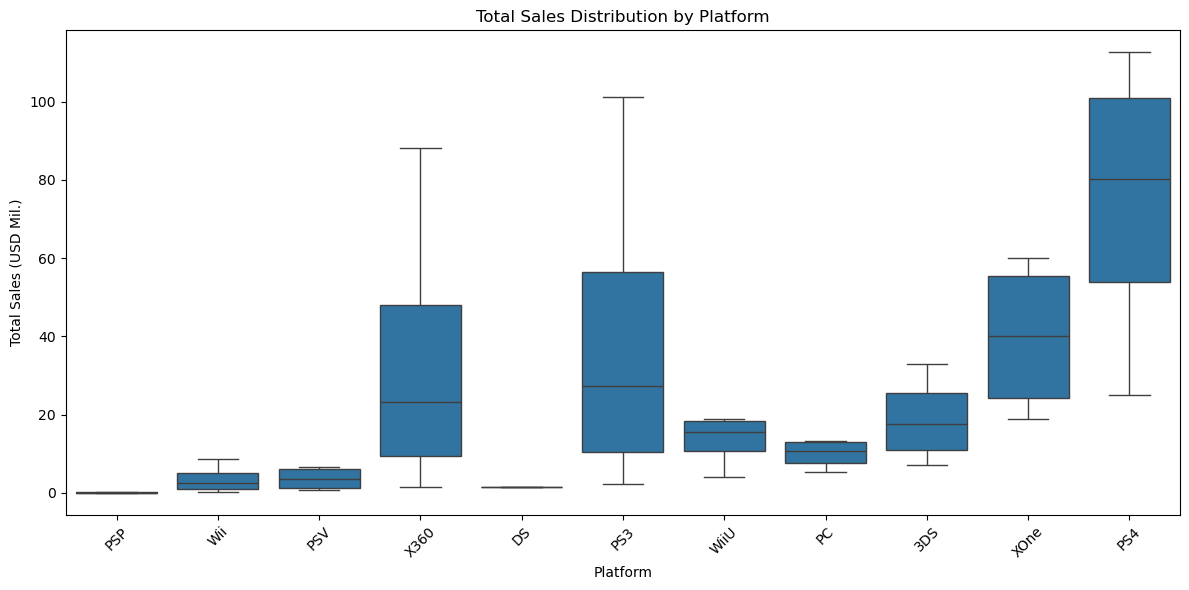

In [31]:
# Create box plot of sales by platform
rel_year_sales = df_relevant.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()
rel_year_sales.sort_values('total_sales', ascending = True, inplace= True)

plt.figure(figsize=(12, 6))
sns.boxplot(x='platform', y='total_sales', data=rel_year_sales)
plt.title('Total Sales Distribution by Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales (USD Mil.)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
# Calculate detailed statistics for each platform
df_relevant.groupby(['platform'])['total_sales'].describe().sort_values('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PS4,392.0,0.760663,1.574127,0.00,0.0300,0.18,0.6925,14.27
X360,186.0,0.732742,1.658126,0.00,0.0800,0.26,0.7875,16.21
XOne,247.0,0.643644,1.033816,0.00,0.0600,0.22,0.6850,7.38
Wii,23.0,0.591739,0.916841,0.00,0.0350,0.18,0.7550,3.58
WiiU,115.0,0.467391,0.835990,0.00,0.0400,0.19,0.5850,5.81
PS3,345.0,0.458203,1.398696,0.00,0.0000,0.08,0.3900,20.07
3DS,303.0,0.248977,0.944461,0.00,0.0000,0.00,0.1200,10.25
PC,190.0,0.209368,0.351521,0.01,0.0300,0.08,0.2300,3.05
DS,8.0,0.192500,0.172026,0.03,0.0675,0.15,0.2525,0.51


## 3.6 Review Score Impact Analysis

Select a popular platform and analyze how reviews affect sales:

In [33]:
# Choose a popular platform based on your previous analysis
ps4_df = df_relevant[df_relevant['platform']=='PS4']

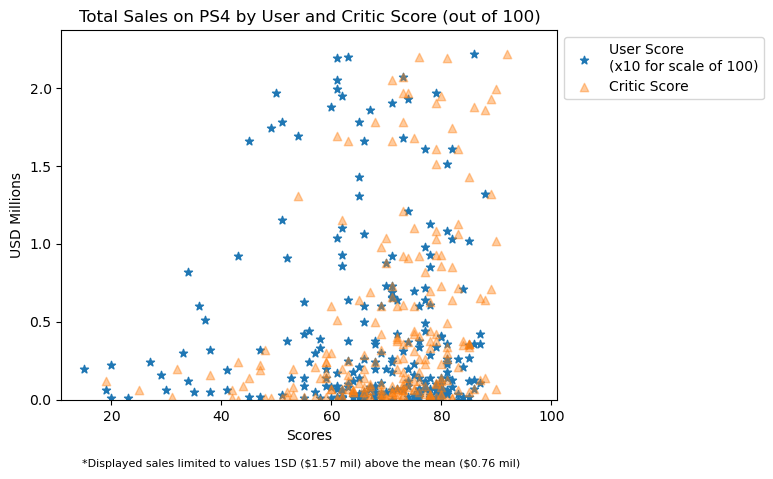

In [34]:
# Create scatter plots for both critic and user scores

plt.scatter(ps4_df['user_score'], ps4_df['total_sales'], color='tab:blue', label='User Score \n(x10 for scale of 100)',
           marker = '*')
plt.scatter(ps4_df['critic_score'], ps4_df['total_sales'], color='tab:orange', label='Critic Score',
           marker = '^', alpha = 0.4)
plt.ylim(0,2.37)
plt.title('Total Sales on PS4 by User and Critic Score (out of 100)')
plt.xlabel('Scores')
plt.ylabel('USD Millions')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.figtext(0.5, -.03,'*Displayed sales limited to values 1SD (\\$1.57 mil) above the mean (\\$0.76 mil)',
            horizontalalignment='center', fontsize=8)
plt.show()

Critic Score Stats: 
 count    252.000000
mean      72.091270
std       12.485992
min       19.000000
max       97.000000
Name: critic_score, dtype: float64
 -----------------------
User Score Stats: 
 count    252.000000
mean      72.091270
std       12.485992
min       19.000000
max       97.000000
Name: critic_score, dtype: float64


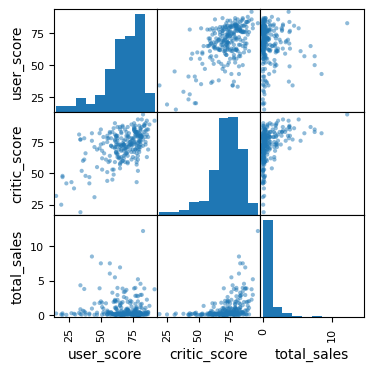

In [35]:
#Scores x Sales Correlations

# Critic Scores
print(f"Critic Score Stats: \n {ps4_df['critic_score'].describe().iloc[[0,1,2,3,7]]}\n -----------------------")
# User Scores
print(f"User Score Stats: \n {ps4_df['critic_score'].describe().iloc[[0,1,2,3,7]]}")

# Calculate correlations
pd.plotting.scatter_matrix(ps4_df[['user_score','critic_score','total_sales']], figsize= [4,4])
plt.show()

### Correlations Statistics

In [36]:
filtered = ps4_df.dropna(subset=['user_score', 'critic_score'])
r_uxc = stats.pearsonr(filtered['user_score'], filtered['critic_score'])[0]
r_uxs = stats.pearsonr(filtered['user_score'], filtered['total_sales'])[0]
r_cxs = stats.pearsonr(filtered['critic_score'], filtered['total_sales'])[0]

print(f"R Values: \n User Score x Critic Score: {r_uxc}")
print(f" User Score x Total Sales: {r_uxs}")
print(f" Critic Score x Total Sales: {r_cxs}")

R Values: 
 User Score x Critic Score: 0.5584959116529671
 User Score x Total Sales: -0.03876463868390681
 Critic Score x Total Sales: 0.4028838833877477


For the PS4 Platform:
- There is a moderate positive correlation between User Score and Critic Score.
- There is a weak negative correlation between User Score and Total Sales.
- There is a moderate positive correlation between Critic Score and Total Sales

## 3.7 Cross-Platform Comparison

To compare sells across platforms, we will look at the 5 highest grossing games across platforms over the past 3 years. 

### Top Sales Across Platforms

In [37]:
# mask for games on multiple platforms
multi_release = df_relevant[df_relevant['name'].duplicated()]['name']

multi_rel_df = df_relevant[df_relevant['name'].isin(multi_release)]
multi_rel_df = multi_rel_df.sort_values(by='name')

#Series of total sales, index is game name
cross_sales = multi_rel_df.groupby('name')['total_sales'].sum()
cross_sales = cross_sales.sort_values(ascending = False)
#turns the Series into dataframe
cross_sales = cross_sales.reset_index()
print(cross_sales.head(5))

                             name  total_sales
0              Grand Theft Auto V        55.16
1            Call of Duty: Ghosts        26.91
2       Call of Duty: Black Ops 3        25.23
3                       Minecraft        22.92
4  Call of Duty: Advanced Warfare        21.63


Because top sales are mostly from the same video game franchise, we will only look at the top selling game from each franchise. 

In [38]:
# function to extract unique game franchises
def extract_franchise(name):
    if ':' in name:
        franchise_part = name.split(':')[0].strip()
        franchise = re.sub(r'\s+((\d+)|([IVXLCDM]+))\s*$', '', franchise_part, flags=re.IGNORECASE)
    else:
        franchise = re.sub(r'\s+((\d+)|([IVXLCDM]+))\s*$', '', name, flags=re.IGNORECASE)
    return franchise

In [39]:
#extract the unique franchises present
df_fran = cross_sales.reset_index()
df_fran['franchise'] = df_fran['name'].apply(extract_franchise)
top_5_fran = pd.Series(df_fran['franchise'].unique()[:5])

#get first instance of cell that matched first 10 char of string
top_fran_mask = cross_sales['name'].str.startswith(tuple(top_5_fran))

#from cross_sales(already sorted by sales amount) and return first game of each unique franchise
first_matches = []
for g in top_5_fran:
    mask = cross_sales['name'].str.contains(g, na=False)
    first_match = cross_sales[mask].head(1)
    if not first_match.empty:
        first_matches.append(first_match) #creates list of single entry dataframes 

# Combine all results
top_unique = pd.concat(first_matches, ignore_index=True)  #concats to a single dateframe
print(f"Top Selling Games (not repeating franchises): \n {top_unique}")

Top Selling Games (not repeating franchises): 
                    name  total_sales
0    Grand Theft Auto V        55.16
1  Call of Duty: Ghosts        26.91
2             Minecraft        22.92
3               FIFA 15        17.23
4         Battlefield 4        13.48


platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
name,,,,,,,,,
Battlefield 4,NaN,1.36,3.22,3.41,NaN,NaN,NaN,3.47,2.02
Call of Duty: Ghosts,NaN,0.69,8.98,3.78,NaN,NaN,0.34,10.20,2.92
FIFA 15,0.46,0.29,4.24,6.03,0.55,0.56,NaN,2.92,2.18
Grand Theft Auto V,NaN,1.17,20.07,12.24,NaN,NaN,NaN,16.21,5.47
Minecraft,NaN,NaN,5.27,4.18,1.06,NaN,0.49,9.16,2.76


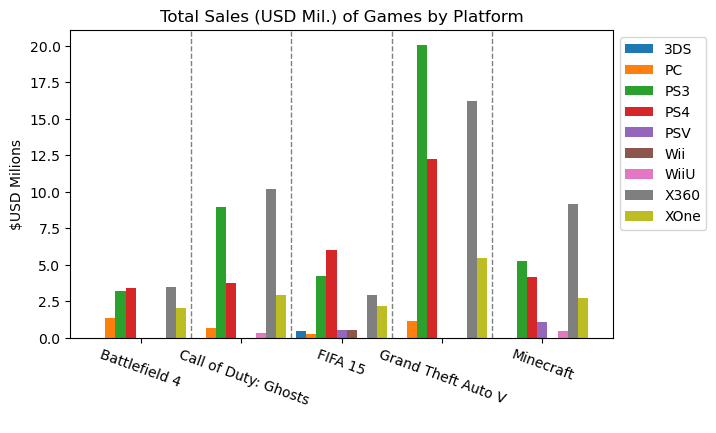

In [40]:
# Compare sales across platforms for these games
# Your code here to analyze and visualize cross-platform performance

top_games_df = multi_rel_df[multi_rel_df['name'].isin(top_unique['name'])].reset_index(drop=True)

top_cross_piv = top_games_df.pivot(index='name', columns='platform', values='total_sales')
display(top_cross_piv)

x_titles = top_cross_piv.index.tolist()
xlabels_new = [re.sub("(.{20})", "\\1\n", label, 0, re.DOTALL) for label in x_titles]

top_cross_piv.plot(kind='bar', width = .9, figsize=[7,4], title='Total Sales (USD Mil.) of Games by Platform',
                  xlabel="", ylabel='\\$USD Milions')

plt.xticks([0,1,2,3,4],labels=xlabels_new, rotation=340)
plt.legend(bbox_to_anchor=(1.0, 1.0))

groups = top_cross_piv.index.tolist()

# Detect in plot boundaries where game changes
boundaries = [i for i in range(1, len(groups)) if groups[i] != groups[i - 1]]

# Add grey vertical lines between groups
for xpos in boundaries:
    plt.axvline(x=xpos - 0.5, color='grey', linestyle='--', linewidth=1)

plt.show()

### Best Selling Games Across Platforms

From 2013 to 2016, the best grossing games (in USD Mill.) were
- Grand Theft Auto V (\\$55.16) with most selling on PS3 (\\$20.07)
- Call of Duty: Ghosts (\\$26.91) with most selling on X360 (\\$10.20)
- Minecraft (\\$22.92) with most selling on X360 (\\$9.16)
- FIFA 15 (\\$17.23) with most selling on PS4 (\\$6.03)
- Battlefield 4 (\\$13.48) with most selling on X360 (\\$3.47)

## 3.8 Genre Analysis

Finally, let's examine the distribution of games by genre:

In [41]:
# Analyze genre performance
relev_genre_grouping = df_relevant.groupby(['genre'])['total_sales']
relev_genre_sales = relev_genre_grouping.describe()
relev_genre_sales = relev_genre_sales.sort_values('mean', ascending = False)
print(relev_genre_sales)

              count      mean       std  min     25%   50%     75%    max
genre                                                                    
Shooter       187.0  1.210535  1.962525  0.0  0.1300  0.45  1.4150  14.27
Sports        214.0  0.678692  1.218402  0.0  0.0300  0.22  0.7000   8.52
Platform       74.0  0.511351  0.679739  0.0  0.0900  0.19  0.6200   3.59
Racing         85.0  0.442235  0.846479  0.0  0.0300  0.12  0.3700   5.81
Action        767.0  0.367314  1.209864  0.0  0.0000  0.05  0.3000  20.07
Misc          155.0  0.345935  0.994194  0.0  0.0000  0.03  0.2600   9.16
Fighting       80.0  0.345750  0.813979  0.0  0.0075  0.08  0.2450   5.12
Role-Playing  292.0  0.324829  1.017131  0.0  0.0000  0.04  0.1925  10.25
Simulation     62.0  0.278065  0.623722  0.0  0.0100  0.07  0.2175   3.32
Strategy       56.0  0.148393  0.273062  0.0  0.0000  0.04  0.2225   1.67
Puzzle         17.0  0.117059  0.258983  0.0  0.0000  0.01  0.1000   1.00
Adventure     245.0  0.072735  0.20926

In [42]:
# Sort genres by total sales
top_genre = relev_genre_grouping.sum().sort_values(ascending=False)
print(top_genre)

genre
Action          281.73
Shooter         226.37
Sports          145.24
Role-Playing     94.85
Misc             53.62
Platform         37.84
Racing           37.59
Fighting         27.66
Adventure        17.82
Simulation       17.24
Strategy          8.31
Puzzle            1.99
Name: total_sales, dtype: float64


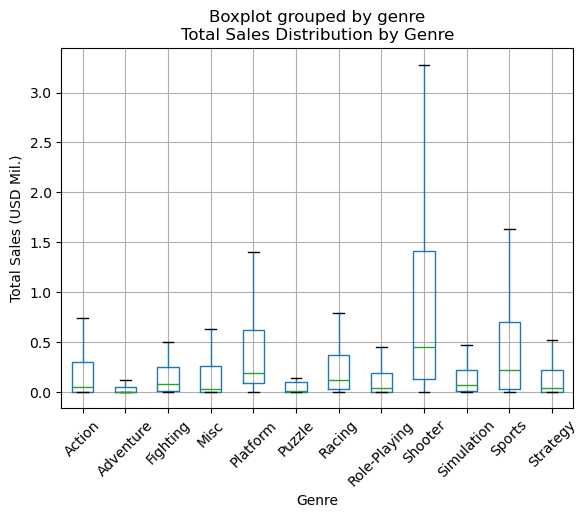

In [43]:
# Visualize genre distributionb
df_relevant.boxplot(column='total_sales', by='genre', showfliers=False)
plt.title('Total Sales Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Sales (USD Mil.)')
plt.xticks(rotation=45)
plt.show()

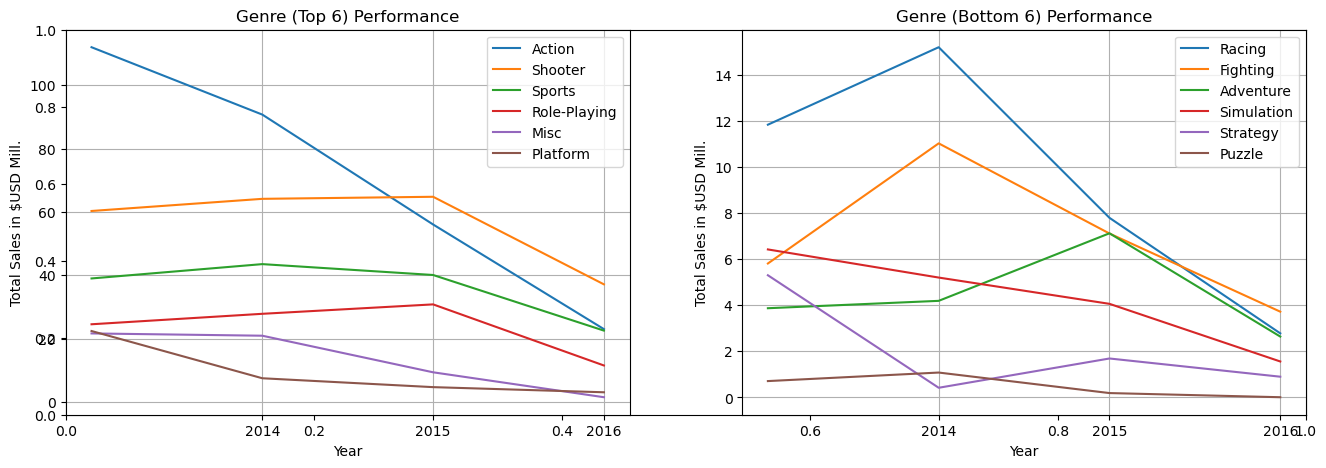

In [44]:
gen_yr_sales_grp = df_relevant.groupby(['genre','year_of_release'])['total_sales'].sum().reset_index()


plt.subplots(figsize=(16, 5))
plt.subplot(1, 2, 1)

for genre in top_genre.reset_index()['genre'].head(6):
    df_plot = gen_yr_sales_grp[gen_yr_sales_grp['genre'] == genre]
    plt.plot(df_plot['year_of_release'], df_plot['total_sales'], label=genre)


plt.title('Genre (Top 6) Performance')
plt.xlabel('Year')
plt.xticks([2014,2015,2016])
plt.ylabel('Total Sales in $USD Mill.')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for genre in top_genre.reset_index()['genre'].tail(6):
   
    df_plot = gen_yr_sales_grp[gen_yr_sales_grp['genre'] == genre]
    plt.plot(df_plot['year_of_release'], df_plot['total_sales'], label=genre)

plt.title('Genre (Bottom 6) Performance')
plt.xlabel('Year')
plt.xticks([2014,2015,2016])
plt.ylabel('Total Sales in $USD Mill.')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
# Calculate market share for each genre

genre_sales = relev_genre_grouping.sum()

total_rel_sales = genre_sales.sum()

proportion_by_genre = genre_sales / total_rel_sales

mshare_genre_df = proportion_by_genre.reset_index()
mshare_genre_df.columns = ['genre', 'sales_proportion']
mshare_genre_df['genre_total_sales'] = genre_sales.reset_index()['total_sales']
print(mshare_genre_df.sort_values('sales_proportion',ascending=False))

           genre  sales_proportion  genre_total_sales
0         Action          0.296477             281.73
8        Shooter          0.238219             226.37
10        Sports          0.152842             145.24
7   Role-Playing          0.099815              94.85
3           Misc          0.056427              53.62
4       Platform          0.039821              37.84
6         Racing          0.039558              37.59
2       Fighting          0.029108              27.66
1      Adventure          0.018753              17.82
9     Simulation          0.018142              17.24
11      Strategy          0.008745               8.31
5         Puzzle          0.002094               1.99


### Findings:
- Action, Shooter, and Sports games were consitently in the top 3
- All game genres saw a decline in sales leading up to 2016

# Step 4: Regional Market Analysis and User Profiles

In this section, we will analyze the gaming market characteristics across three major regions: North America (NA), Europe (EU), and Japan (JP). Our analysis will focus on platform preferences, genre popularity, and the impact of ESRB ratings in each region.

## 4.1 Regional Platform Analysis

Let's begin by examining platform performance across different regions:

In [46]:
# Function to analyze platform performance by region

def reg_analysis(region, grouping, game_char):
    region_col = region + '_sales'
    region_grouping = df_relevant.groupby(grouping)[region_col]
    grouping_sales = region_grouping.sum().rename('grouping_sales')
    region_stats = region_grouping.describe(percentiles=[])
    region_stats.insert(0, 'total_sales', grouping_sales)
    return region_stats.sort_values('total_sales', ascending=False)

In [47]:
# Analyze each region
for r in ['na', 'eu', 'jp', 'other']:
    print(f"Platform Sales in Region {r}:")
    print(reg_analysis(r,'platform','total_sales'))
    print('-----------------------')

Platform Sales in Region na:
          total_sales  count      mean       std  min    50%   max
platform                                                          
PS4            108.74  392.0  0.277398  0.583723  0.0  0.060  6.03
XOne            93.12  247.0  0.377004  0.630618  0.0  0.120  4.59
X360            81.66  186.0  0.439032  1.021400  0.0  0.150  9.66
PS3             63.50  345.0  0.184058  0.521613  0.0  0.030  7.02
3DS             38.20  303.0  0.126073  0.499331  0.0  0.000  5.28
WiiU            29.21  115.0  0.254000  0.473655  0.0  0.090  3.15
PC              11.17  190.0  0.058789  0.127467  0.0  0.000  1.00
Wii              6.56   23.0  0.285217  0.505154  0.0  0.040  1.88
PSV              5.04  358.0  0.014078  0.035851  0.0  0.000  0.32
DS               0.57    8.0  0.071250  0.096279  0.0  0.015  0.22
PSP              0.00   67.0  0.000000  0.000000  0.0  0.000  0.00
-----------------------
Platform Sales in Region eu:
          total_sales  count      mean       st

### Cross-Regional Platform Comparison

Let's create a comparative analysis of platform performance across regions:

In [48]:
# Create a comparative platform analysis

all_plat = reg_analysis('total','platform','total_sales')
all_plat.sort_values(by='total_sales', ascending=False, inplace = True)
display(all_plat)

,total_sales,count,mean,std,min,50%,max
platform,,,,,,,
PS4,298.18,392.0,0.760663,1.574127,0.00,0.18,14.27
XOne,158.98,247.0,0.643644,1.033816,0.00,0.22,7.38
PS3,158.08,345.0,0.458203,1.398696,0.00,0.08,20.07
X360,136.29,186.0,0.732742,1.658126,0.00,0.26,16.21
3DS,75.44,303.0,0.248977,0.944461,0.00,0.00,10.25
WiiU,53.75,115.0,0.467391,0.835990,0.00,0.19,5.81
PC,39.78,190.0,0.209368,0.351521,0.01,0.08,3.05
PSV,14.40,358.0,0.040223,0.110347,0.00,0.00,1.06
Wii,13.61,23.0,0.591739,0.916841,0.00,0.18,3.58


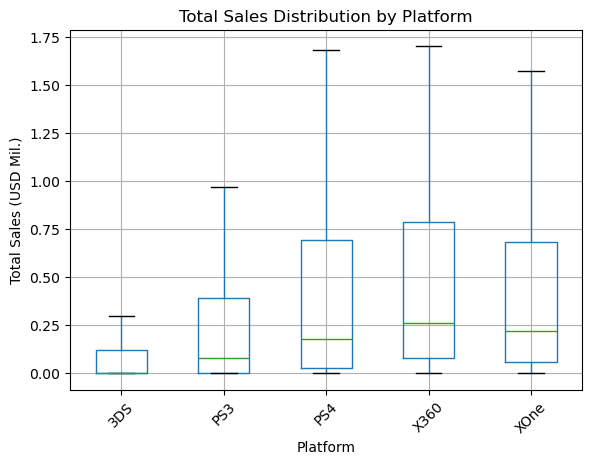

In [49]:
# Visualize cross-regional comparison for top platforms
top_plat = all_plat.index.to_list()[0:5]

df_top_plat = df_relevant[df_relevant['platform'].isin(top_plat)]
df_top_plat.boxplot(column='total_sales', by='platform', showfliers=False)
plt.suptitle('')
plt.title('Total Sales Distribution by Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales (USD Mil.)')
plt.xticks(rotation=45)
plt.show()

## 4.2 Regional Genre Analysis

Now let's examine genre preferences across regions:

In [50]:
# Function to analyze genre performance by region

for r in ['na', 'eu', 'jp', 'other']:
    print(f"Genre Sales in Region {r}:")
    print(reg_analysis(r,'genre','total_sales').sort_values('total_sales',ascending=False))
    print('-----------------------')

Genre Sales in Region na:
              total_sales  count      mean       std  min    50%   max
genre                                                                 
Action             126.11  767.0  0.164420  0.542460  0.0  0.020  9.66
Shooter            109.74  187.0  0.586845  0.993237  0.0  0.200  6.73
Sports              65.27  214.0  0.305000  0.489979  0.0  0.080  2.49
Role-Playing        46.40  292.0  0.158904  0.504518  0.0  0.020  5.28
Misc                27.49  155.0  0.177355  0.545608  0.0  0.010  5.70
Platform            18.14   74.0  0.245135  0.365252  0.0  0.090  2.11
Fighting            15.55   80.0  0.194375  0.507094  0.0  0.045  3.27
Racing              12.96   85.0  0.152471  0.391191  0.0  0.030  3.15
Adventure            7.14  245.0  0.029143  0.078982  0.0  0.000  0.55
Simulation           4.86   62.0  0.078387  0.193731  0.0  0.000  1.00
Strategy             3.28   56.0  0.058571  0.130027  0.0  0.000  0.83
Puzzle               0.83   17.0  0.048824  0.12839

### Cross-Regional Genre Comparison

Let's compare genre preferences across regions:

In [51]:
# Create a comparative genre analysis
all_genre = reg_analysis('total','genre','total_sales')
all_genre.sort_values(by='total_sales', ascending=False, inplace = True)
display(all_genre)

,total_sales,count,mean,std,min,50%,max
genre,,,,,,,
Action,281.73,767.0,0.367314,1.209864,0.0,0.05,20.07
Shooter,226.37,187.0,1.210535,1.962525,0.0,0.45,14.27
Sports,145.24,214.0,0.678692,1.218402,0.0,0.22,8.52
Role-Playing,94.85,292.0,0.324829,1.017131,0.0,0.04,10.25
Misc,53.62,155.0,0.345935,0.994194,0.0,0.03,9.16
Platform,37.84,74.0,0.511351,0.679739,0.0,0.19,3.59
Racing,37.59,85.0,0.442235,0.846479,0.0,0.12,5.81
Fighting,27.66,80.0,0.345750,0.813979,0.0,0.08,5.12
Adventure,17.82,245.0,0.072735,0.209264,0.0,0.00,1.61


## 4.3 ESRB Rating Impact Analysis

Finally, let's examine how ESRB ratings affect sales in each region:

In [52]:
reg_analysis ('na', 'rating', 'total_sales')

,total_sales,count,mean,std,min,50%,max
rating,,,,,,,
M,165.27,370.0,0.446676,0.911315,0.0,0.14,9.66
Unknown,89.42,977.0,0.091525,0.449718,0.0,0.00,6.03
E,79.05,302.0,0.261755,0.472048,0.0,0.05,3.15
E10+,54.24,252.0,0.215238,0.317026,0.0,0.12,2.49
T,49.79,333.0,0.149520,0.335906,0.0,0.04,2.78


In [53]:
# Analyze ESRB impact for each region

for r in ['na', 'eu', 'jp', 'other']:
    print(f"ESRB Sales in Region {r}:")
    print(reg_analysis(r,'rating','total_sales'))
    print('-----------------------')

ESRB Sales in Region na:
         total_sales  count      mean       std  min   50%   max
rating                                                          
M             165.27  370.0  0.446676  0.911315  0.0  0.14  9.66
Unknown        89.42  977.0  0.091525  0.449718  0.0  0.00  6.03
E              79.05  302.0  0.261755  0.472048  0.0  0.05  3.15
E10+           54.24  252.0  0.215238  0.317026  0.0  0.12  2.49
T              49.79  333.0  0.149520  0.335906  0.0  0.04  2.78
-----------------------
ESRB Sales in Region eu:
         total_sales  count      mean       std  min    50%   max
rating                                                           
M             145.57  370.0  0.393432  0.811770  0.0  0.130  9.09
E              83.36  302.0  0.276026  0.708950  0.0  0.055  6.12
Unknown        78.91  977.0  0.080768  0.357619  0.0  0.000  5.86
E10+           42.69  252.0  0.169405  0.207409  0.0  0.100  1.39
T              41.95  333.0  0.125976  0.279076  0.0  0.040  2.50
---------

# Hypothesis Tests

—Average user ratings of the Xbox One and PC platforms are the same.

$H_0$: The mean difference between User Scores of games on X-Box and the same game on PC is not statistically significantly different than 0.   \
$H_A$: The mean difference between User Scores of games on X-Box and the same game on PC is statistically significantly different than 0.

Criteria:
- To compare platforms with regard to user score, we will only look at games that have been published on both X-box and on PC
- Because we are dealing with two-scores from the same base-game (dependent samples), we will use a paired-samples T-test. 


—Average user ratings for the Action and Sports genres are different.

$H_0$: There is no statistically significant difference between Action and Sports genres with regard to Average User Score. \
$H_A$: There is a statistically significant difference between Action and Sports genres with regard to Average User Score.

Criteria:
- Because we are dealing with two seperate catagories of games (independent samples), with unequal variances (Levene's p = 0.002), we will use a Welch's independent samples T-test. 

For both tests we have set *alpha* at a threshold of 0.05.


## Average Platform Ratings (XBox v PC)

In [54]:
x_pc = ['X360', 'XOne', 'PC']
filtered = df_relevant[df_relevant['platform'].isin(x_pc)]

platforms_per_game = filtered.groupby('name')['platform'].unique()

#Find games that have BOTH PC and at least one of X360 or XOne
desired_games = platforms_per_game[
    platforms_per_game.apply(lambda x: ('PC' in x) and bool(set(x) & {'X360', 'XOne'}))
].index

x_pc_df = df_relevant[df_relevant['name'].isin(desired_games)]

xbox_games = x_pc_df[x_pc_df['platform'].isin(['XOne', 'X360'])]
pc_games = x_pc_df[x_pc_df['platform'] == 'PC']

xbox_games = xbox_games.rename(columns={'user_score':'x_user_score'})
pc_games = pc_games.rename(columns={'user_score':'pc_user_score'})

x_pc_scores = pd.merge(
    pc_games[['name', 'pc_user_score']],   # select columns from first df
    xbox_games[['name', 'x_user_score']],   # select columns from second df
    on='name'                        # merge on 'name'
)

x_pc_scores = x_pc_scores.dropna()

t_statistic, p_value = stats.ttest_rel(x_pc_scores['pc_user_score'], x_pc_scores['x_user_score'])

print(f"T-test: p-value: {p_value}")

x_pc_scores = x_pc_scores.describe()

pc_sem = x_pc_scores['pc_user_score']['std'] / np.sqrt(x_pc_scores['pc_user_score']['count'])
xbox_sem = x_pc_scores['x_user_score']['std'] / np.sqrt(x_pc_scores['x_user_score']['count'])
display(x_pc_scores)
print(f"SEM of X-Box User Scores: {xbox_sem}")
print(f"SEM of PC User Scores: {pc_sem}")


T-test: p-value: 0.001772620133347205


,pc_user_score,x_user_score
count,142.000000,142.000000
mean,61.848086,65.279852
std,17.054940,14.257790
min,14.000000,17.000000
25%,48.000000,57.000000
50%,65.000000,68.000000
75%,76.000000,75.000000
max,93.000000,92.000000


SEM of X-Box User Scores: 1.1964871426996493
SEM of PC User Scores: 1.4312188106046946


<b>Findings:</b> Over the past 3 years, 142 games were published on both the X-Box (360 or One) and the PC. A dependent samples T-test were perfomed on games to compare user-scores (scaled to 100) on X-box and on PC. 

Given that the level of significance (p < 0.01) for the t-test was less than alpha (0.05), we must reject the null hypothesis and conclude that there is a statistically significant difference between a game's user score (scaled to 100) when rated X-Box and PC. That is, for each game, X-box user scores (mean = 65.27 ± 1.20 CI: 95%) were more likely to be higher than that of PC (mean = 61.85 ± 1.43 CI: 95%).

## Average Genre Ratings (Action v Sport)

In [55]:
act_sport = ['Action', 'Sports']
act_sport_df = df_relevant[df_relevant['genre'].isin(act_sport)]

act_sport_df = act_sport_df.dropna()
action_scores = act_sport_df[act_sport_df['genre']=='Action']['user_score']
sport_scores = act_sport_df[act_sport_df['genre']=='Sports']['user_score']

act_desc = action_scores.describe()
sport_desc = sport_scores.describe()

act_sem = act_desc.loc['std'] / np.sqrt(act_desc.loc['count'])
sport_sem = sport_desc.loc['std'] / np.sqrt(sport_desc.loc['count'])

lev_stat, lev_p = stats.levene(action_scores,sport_scores,center= 'mean')

t_stat, t_p = stats.ttest_ind(sport_scores, action_scores, equal_var=False)

print(f"Levene p-value: {lev_p}")
print(f"Indep. T-test p-value: {t_p}")
print()
print(f"Action: {act_desc}")
print()
print(f"Sport: {sport_desc}")
print()
print(f"Action SEM: {act_sem}")
print()
print(f"Sports SEM: {sport_sem}")

Levene p-value: 0.050790502900996036
Indep. T-test p-value: 2.7497027879699628e-14

Action: count    314.000000
mean      69.309800
std       12.821404
min       20.000000
25%       64.000000
50%       73.000000
75%       78.000000
max       91.000000
Name: user_score, dtype: float64

Sport: count    112.000000
mean      56.371824
std       14.621089
min       15.000000
25%       44.750000
50%       58.000000
75%       66.250000
max       87.000000
Name: user_score, dtype: float64

Action SEM: 0.7235536964561945

Sports SEM: 1.3815630399818408


<b>Findings:</b> Over the past 3 years, 306 actions games and 107 Sport games were published across platforms. A independent samples T-test were performed, accounting for equal between group variance. (W = 0.07).

Given that the level of significance (p < 0.001) for the t-test was less than alpha (0.05), we must reject the null hypothesis and conclude that there is a statistically significant difference between action games and sports games with regard to user score (scaled to 100). That is, action games (mean = 69.09 ± 0.74 CI: 95%) were more likely to have higher user score than that of sports games (mean = 56.49 ± 1.42 CI: 95%).

# Conclusion


Overall, the top performing platforms over the past 3 years were PS4, XOne, PS3, and X360. PS4, newer to market, is a likely potential top performer. PSV and 3DS are potential rising stars. 

Over this time, the most popular games (taking only unique franchises) were Grand Theft Auto V, Call of Duty: Ghosts, Minecraft, FIFA 15, and Battlefield 4. This accords with the overall performing genres -- action, sports, and shooter. These trends were consistently seen across all regions. Of note, not accounting for unique franchises, Call of Duty and FIFA iterations occupied 2 of the 5 top selling games each. 

A moderate postive correlation was found between user score x total sales and user score x critic scores for games. Only a weak negative correalations was found between user score x total sales. 

When looking at games released on both XBox and PC, Xbox games were more likely to yeild higher user scores for the same game (p<0.01). When looking at score between action and sports games, action games were more likely to yeild higher user scores (p<0.001).

Ultimately, while were are seeing a overall slowing of the market, there are specific avenues of potential growth. For the 2017 fiscal year it may be beneficial to consider:
* Focusing on newer platforms with well performing prior iterations (i.e. XOne and PS4)
* Action and Shooter games of known franchises, i.e.
   * Call of Duty (Sold well on PS4)
   * Grand Theft Auto (Sold well on PS4)

Further regression analysis on game score, score of other games in the same franchise, cost of game at time of release, and platform may offer us a better predictive picture. 
